In [513]:
import Nets
using CoordinateTransformations
using ForwardDiff
using MLDataPattern
using Plots; pyplot()
using ProgressMeter

In [514]:
reload("Nets")

INFO: Recompiling stale cache file /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Nets.ji for module Nets.


In [515]:
f(x) = [sin(2 * x[1])]

X = [[x] for x in linspace(-pi, pi, 60)]
Y = [hcat(f(x), ForwardDiff.jacobian(f, x)) for x in X];

data = collect(zip(X, Y))
train_data, test_data = splitobs(shuffleobs(data), 1/6);

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
for (x, yJ) in train_data
    y = yJ[:, 1]
    J = yJ[:, 2:end]
    @assert y ≈ f(x)
    @assert J ≈ ForwardDiff.jacobian(f, x)
end

u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

for (u, vJ) in train_data_scaled
    v = vJ[:, 1]
    J = vJ[:, 2:end]
    @assert isapprox(v |> v_to_y, u |> u_to_x |> f, atol=1e-6)
    @assert J ≈ ForwardDiff.jacobian(u -> u |> u_to_x |> f |> y_to_v, u)
    @assert maximum(abs, J) <= 1.0 + 1e-5
    
end

In [516]:
widths = [1, 16, 16, 16, 1]

function sensitive_loss(λ)
    q = [1.0-λ λ]
    (params, x, y) -> begin
            sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
    end
end

sensitive_loss (generic function with 1 method)

In [517]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 1000;

mean((xy->begin  # In[518], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.5172980604385322


Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

mean((xy->begin  # In[518], line 15:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 3.7819380274495176


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06



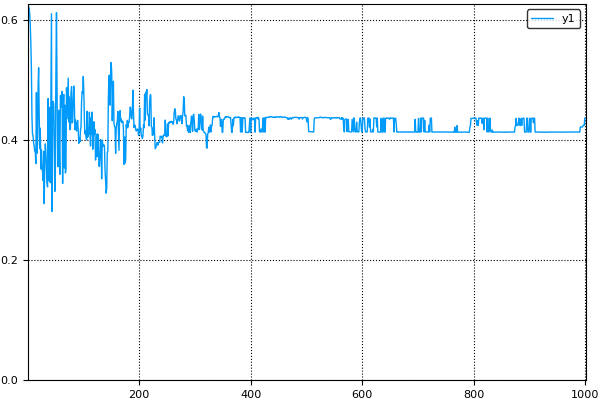

In [518]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(1.0)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=2))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))




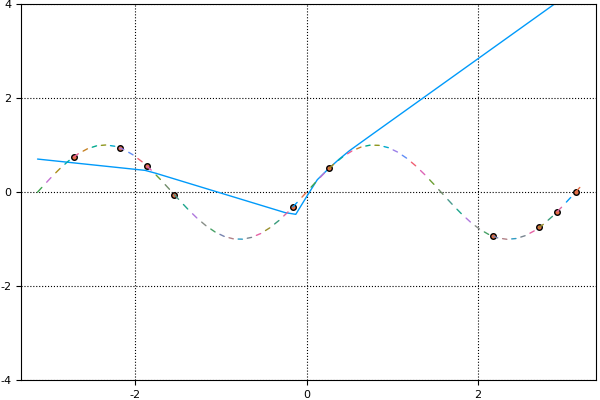

In [519]:
plt = plot(linspace(-pi, pi, 51), x -> net([x])[1], legend=nothing, ylim=(-4, 4))
plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
for (x, y) in zip(X, Y)
    eps = 5e-2
    plot!(plt, [x[1], x[1] + eps], [y[1], y[1] + eps * y[2]])
end
plt

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

mean((xy->begin  # In[520], line 7:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.2845327992836616


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05



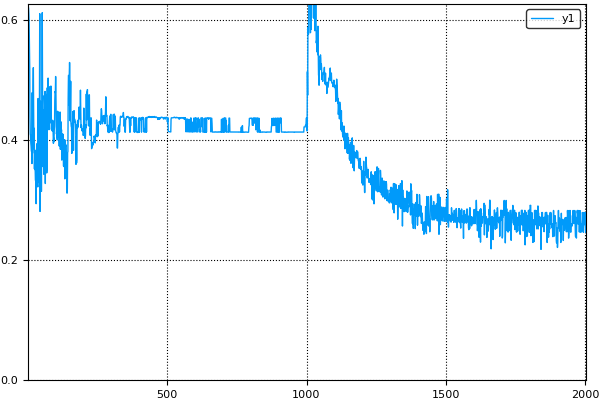

In [520]:
train_loss = sensitive_loss(0.5)
@showprogress for i in 1:nepoch
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.005 * 0.99^i, batch_size=2))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))


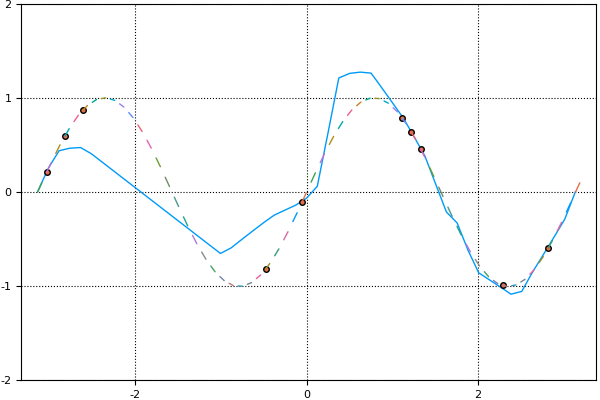

In [215]:
plt = plot(linspace(-pi, pi, 51), x -> net([x])[1], legend=nothing, ylim=(-2, 2))
plot!(plt, [x[1] for (x, y) in train_data], [y[1] for (x, y) in train_data], line=nothing, marker=:circle)
for (x, y) in zip(X, Y)
    eps = 5e-2
    plot!(plt, [x[1], x[1] + eps], [y[1], y[1] + eps * y[2]])
end
plt

In [ ]:
module Foo

